In [1]:
import sys
import stlearn as st
st.settings.set_figure_params(dpi=300)
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sys
file = Path("../stimage").resolve()
parent= file.parent
sys.path.append(str(parent))
from PIL import Image
from stimage._utils import gene_plot, Read10X, ReadOldST, tiling
from stimage._model import CNN_NB_multiple_genes
# from stimage._data_generator import DataGenerator
from stimage._imgaug import seq_aug
import tensorflow as tf
import seaborn as sns
sns.set_style("white")
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from scipy import stats
import numpy as np
import anndata
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet
from tensorflow.keras.preprocessing import image

In [2]:
def negative_binomial_layer(x):
    """
    Lambda function for generating negative binomial parameters
    n and p from a Dense(2) output.
    Assumes tensorflow 2 backend.

    Usage
    -----
    outputs = Dense(2)(final_layer)
    distribution_outputs = Lambda(negative_binomial_layer)(outputs)

    Parameters
    ----------
    x : tf.Tensor
        output tensor of Dense layer

    Returns
    -------
    out_tensor : tf.Tensor

    """

    # Get the number of dimensions of the input
    num_dims = len(x.get_shape())

    # Separate the parameters
    n, p = tf.unstack(x, num=2, axis=-1)

    # Add one dimension to make the right shape
    n = tf.expand_dims(n, -1)
    p = tf.expand_dims(p, -1)

    # Apply a softplus to make positive
    n = tf.keras.activations.softplus(n)

    # Apply a sigmoid activation to bound between 0 and 1
    p = tf.keras.activations.sigmoid(p)

    # Join back together again
    out_tensor = tf.concat((n, p), axis=num_dims - 1)

    return out_tensor


def negative_binomial_loss(y_true, y_pred):
    """
    Negative binomial loss function.
    Assumes tensorflow backend.

    Parameters
    ----------
    y_true : tf.Tensor
        Ground truth values of predicted variable.
    y_pred : tf.Tensor
        n and p values of predicted distribution.

    Returns
    -------
    nll : tf.Tensor
        Negative log likelihood.
    """

    # Separate the parameters
    n, p = tf.unstack(y_pred, num=2, axis=-1)

    # Add one dimension to make the right shape
    n = tf.expand_dims(n, -1)
    p = tf.expand_dims(p, -1)

    # Calculate the negative log likelihood
    nll = (
            tf.math.lgamma(n)
            + tf.math.lgamma(y_true + 1)
            - tf.math.lgamma(n + y_true)
            - n * tf.math.log(p)
            - y_true * tf.math.log(1 - p)
    )

    return nll

In [3]:
class DataGenerator_VAE(keras.utils.Sequence):
    'Generates data for Keras'

    def __init__(self, adata, dim=(299, 299), n_channels=3, genes=None, aug=False, tile_path="tile_path"):
        'Initialization'
        self.dim = dim
        self.adata = adata
        self.n_channels = n_channels
        self.genes = genes
        self.num_genes = len(genes)
        self.aug = aug
        self.tile_path = tile_path
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(self.adata.n_obs)

    def __getitem__(self, index):
        'Generate one batch of data'
        # Find list of IDs
        obs_temp = self.adata.obs_names[index]

        # Generate data
        X_img = self._load_img(obs_temp)
        y = self._load_label(obs_temp)

        return X_img, X_img, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.adata.n_obs)

    def _load_img(self, obs):
        img_path = self.adata.obs.loc[obs, 'tile_path']
        X_img = image.load_img(img_path, target_size=self.dim)
        X_img = image.img_to_array(X_img).astype('float64')
        #         X_img = np.expand_dims(X_img, axis=0)
        #         n_rotate = np.random.randint(0, 4)
        #         X_img = np.rot90(X_img, k=n_rotate, axes=(1, 2))
        if self.aug:
            X_img = seq_aug(image=X_img)
#         X_img = preprocess_resnet(X_img)
        X_img /= 255.0
        return X_img

    def _load_label(self, obs):
        batch_adata = self.adata[obs, self.genes].copy()

        return batch_adata.to_df().to_numpy().reshape(self.num_genes,)

    def get_classes(self):
        return self.adata.to_df().loc[:, self.genes]



In [4]:
BASE_PATH = Path("/clusterdata/uqxtan9/Xiao/STimage/dataset/breast_cancer_10x_visium")
TILE_PATH = Path("/tmp") / "tiles"
TILE_PATH.mkdir(parents=True, exist_ok=True)

SAMPLE = "block1"
Sample1 = st.Read10X(BASE_PATH / SAMPLE, 
                  library_id=SAMPLE, 
                  count_file="V1_Breast_Cancer_Block_A_Section_1_filtered_feature_bc_matrix.h5",
                  quality="fulres",)
                  #source_image_path=BASE_PATH / SAMPLE /"V1_Breast_Cancer_Block_A_Section_1_image.tif")
img = plt.imread(BASE_PATH / SAMPLE /"V1_Breast_Cancer_Block_A_Section_1_image.tif", 0)
Sample1.uns["spatial"][SAMPLE]['images']["fulres"] = img

SAMPLE = "block2"
Sample2 = st.Read10X(BASE_PATH / SAMPLE, 
                  library_id=SAMPLE, 
                  count_file="V1_Breast_Cancer_Block_A_Section_2_filtered_feature_bc_matrix.h5",
                  quality="fulres",)
                  #source_image_path=BASE_PATH / SAMPLE /"V1_Breast_Cancer_Block_A_Section_1_image.tif")
img = plt.imread(BASE_PATH / SAMPLE /"V1_Breast_Cancer_Block_A_Section_2_image.tif", 0)
Sample2.uns["spatial"][SAMPLE]['images']["fulres"] = img

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [5]:
gene_list=["SLITRK6", "PGM5", "LINC00645", 
           "TTLL12", "COX6C", "CPB1",
           "KRT5", "MALAT1"]
gene_list

['SLITRK6', 'PGM5', 'LINC00645', 'TTLL12', 'COX6C', 'CPB1', 'KRT5', 'MALAT1']

In [6]:
for adata in [
    Sample1,
    Sample2,
]:
#     count_df = adata.to_df()
#     count_df[count_df <=1] = 0
#     count_df[count_df >1] = 1
#     adata.X = count_df
#     adata[:,gene_list]
    st.pp.filter_genes(adata,min_cells=3)
#     st.pp.normalize_total(adata)
    st.pp.log1p(adata)
#     st.pp.scale(adata)

    # pre-processing for spot image
    TILE_PATH_ = TILE_PATH / list(adata.uns["spatial"].keys())[0]
    TILE_PATH_.mkdir(parents=True, exist_ok=True)
    tiling(adata, TILE_PATH_, crop_size=512,target_size=224)

Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]


Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]


In [8]:
n_genes = len(gene_list)
training_index = Sample1.obs.sample(frac=0.7, random_state=1).index
# training_dataset = Sample1[training_index,].copy()

training_dataset = Sample1.copy()

valid_index = Sample1.obs.index.isin(training_index)
valid_dataset = Sample1[~valid_index,].copy()

test_dataset = Sample2.copy()

train_gen = tf.data.Dataset.from_generator(
            lambda:DataGenerator_VAE(adata=training_dataset, 
                          genes=gene_list, aug=False,dim=(224,224)),
            output_types=(tf.float32, tf.float32, tf.float32), 
            output_shapes=([224,224,3], [224,224,3], [n_genes,])
)
train_gen_ = train_gen.shuffle(buffer_size=500).batch(8).repeat(3).cache().prefetch(tf.data.experimental.AUTOTUNE)
valid_gen = tf.data.Dataset.from_generator(
            lambda:DataGenerator_VAE(adata=valid_dataset, 
                          genes=gene_list,dim=(224,224)), 
            output_types=(tf.float32, tf.float32, tf.float32), 
            output_shapes=([224,224,3], [224,224,3], [n_genes,])
)
valid_gen_ = valid_gen.shuffle(buffer_size=500).batch(8).repeat(3).cache().prefetch(tf.data.experimental.AUTOTUNE)
test_gen = tf.data.Dataset.from_generator(
            lambda:DataGenerator_VAE(adata=test_dataset, 
                          genes=gene_list,dim=(224,224)), 
            output_types=(tf.float32, tf.float32, tf.float32), 
            output_shapes=([224,224,3], [224,224,3], [n_genes,])
)
test_gen_ = test_gen.batch(1)

In [9]:
class VAE(tf.keras.Model):
    """Variational autoencoder."""

    def __init__(self, latent_dim, n_genes):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(224, 224, 3)),
                tf.keras.layers.Conv2D(
                    filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Conv2D(
                    filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Conv2D(
                    filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Conv2D(
                    filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
                
                tf.keras.layers.LeakyReLU(),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(latent_dim + latent_dim),
            ]
        )

        self.decoder_image = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                tf.keras.layers.Dense(units=14*14*32, activation=tf.nn.relu),
                tf.keras.layers.Reshape(target_shape=(14, 14, 32)),
                tf.keras.layers.LeakyReLU(),
                tf.keras.layers.Conv2DTranspose(
                    filters=64, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Conv2DTranspose(
                    filters=64, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Conv2DTranspose(
                    filters=64, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Conv2DTranspose(
                    filters=32, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                tf.keras.layers.Conv2DTranspose(
                    filters=3, kernel_size=3, strides=1, padding='same'),
            ]
        )
        self.decoder_gene = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                tf.keras.layers.Dense(units=n_genes, activation="linear")
            ]
        )

#     @tf.function
#     def decoder_gene(self, x):
#         output_layers = []
#         for i in range(n_genes):
#             output = tf.keras.layers.Dense(2)(x)
#             output_layers.append(tf.keras.layers.Lambda(negative_binomial_layer, name="gene_{}".format(i))(output))
#         return output_layers

#     @tf.function
#     def decoder_gene(self, x):
#         output_layers = []
#         for i in range(n_genes):
#             output = tf.keras.layers.Dense(2)(x)
#             output_layers.append(tf.keras.layers.Lambda(negative_binomial_layer, name="gene_{}".format(i))(output))
#         return output_layers
    
    @tf.function
    def sample_image(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decoder_image(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode_image(self, z, apply_sigmoid=True):
        logits = self.decoder_image(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits
    
    def decode_genes(self, z):
        genes = self.decoder_gene(z)
        return genes

In [10]:
epochs = 20

latent_dim = 512
optimizer = tf.keras.optimizers.Adam(1e-3)

model = VAE(latent_dim, n_genes)

In [14]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis)


def compute_loss(model, x, gene, n_genes, beta=0.01):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    
    x_logit = model.decode_image(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    
    pred_gene = model.decode_genes(z)
#     nll_gene = []
#     for i in range(n_genes):
#         nll_gene.append(negative_binomial_loss(gene[i], pred_gene[i]))
    mse = tf.square(tf.subtract(gene, pred_gene)) # ~~~
#     return tf.reduce_mean(mse)
    return -tf.reduce_mean(logpx_z - beta*(logqz_x - logpz)) * 1/3 * 0.0001 +  tf.reduce_mean(mse)  # ~~~
#     return -tf.reduce_mean(logpx_z + logpz - logqz_x) #* 1/3 * 0.0001 #+  tf.reduce_mean(mse)  # ~~~


@tf.function
def train_step(model, x, gene, optimizer, n_genes):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x, gene, n_genes)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [15]:
import time

for epoch in range(1, epochs + 1):
    start_time = time.time()
    for image_, _, label_ in train_gen_:
        train_step(model, image_, label_, optimizer, n_genes)
    end_time = time.time()

    loss = tf.keras.metrics.Mean()
    for image_, _, label_ in train_gen_:
        loss(compute_loss(model, image_, label_, n_genes))
    lss = loss.result()
    print('Epoch: {}, Test set loss: {}, time elapse for current epoch: {}'
        .format(epoch, lss, end_time - start_time))

Epoch: 1, Test set loss: 3.8369863033294678, time elapse for current epoch: 78.89258313179016
Epoch: 2, Test set loss: 3.7448036670684814, time elapse for current epoch: 17.503206968307495
Epoch: 3, Test set loss: 3.6328322887420654, time elapse for current epoch: 16.59421706199646
Epoch: 4, Test set loss: 3.5345377922058105, time elapse for current epoch: 16.31278133392334
Epoch: 5, Test set loss: 3.4678285121917725, time elapse for current epoch: 16.315804481506348
Epoch: 6, Test set loss: 3.422652244567871, time elapse for current epoch: 16.406946659088135
Epoch: 7, Test set loss: 3.415637731552124, time elapse for current epoch: 16.36034107208252
Epoch: 8, Test set loss: 3.3957459926605225, time elapse for current epoch: 16.210381507873535
Epoch: 9, Test set loss: 3.417086124420166, time elapse for current epoch: 16.592683792114258
Epoch: 10, Test set loss: 3.40586256980896, time elapse for current epoch: 16.067523956298828
Epoch: 11, Test set loss: 3.374865770339966, time elapse f

In [97]:
#         model1 = tf.keras.Sequential(
#             [
#                 tf.keras.layers.InputLayer(input_shape=(224, 224, 3)),
#                 tf.keras.layers.Conv2D(
#                     filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
#                 tf.keras.layers.Conv2D(
#                     filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
#                 tf.keras.layers.Flatten(),
#                 # No activation
#                 tf.keras.layers.Dense(latent_dim + latent_dim),
#             ]
#         )

#         model2 = tf.keras.Sequential(
#             [
#                 tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
#                 tf.keras.layers.Dense(units=56*56*32, activation=tf.nn.relu),
#                 tf.keras.layers.Reshape(target_shape=(56, 56, 32)),
#                 tf.keras.layers.Conv2DTranspose(
#                     filters=64, kernel_size=3, strides=2, padding='same',
#                     activation='relu'),
#                 tf.keras.layers.Conv2DTranspose(
#                     filters=32, kernel_size=3, strides=2, padding='same',
#                     activation='relu'),
#                 # No activation
#                 tf.keras.layers.Conv2DTranspose(
#                     filters=3, kernel_size=3, strides=1, padding='same'),
#             ]
#         )

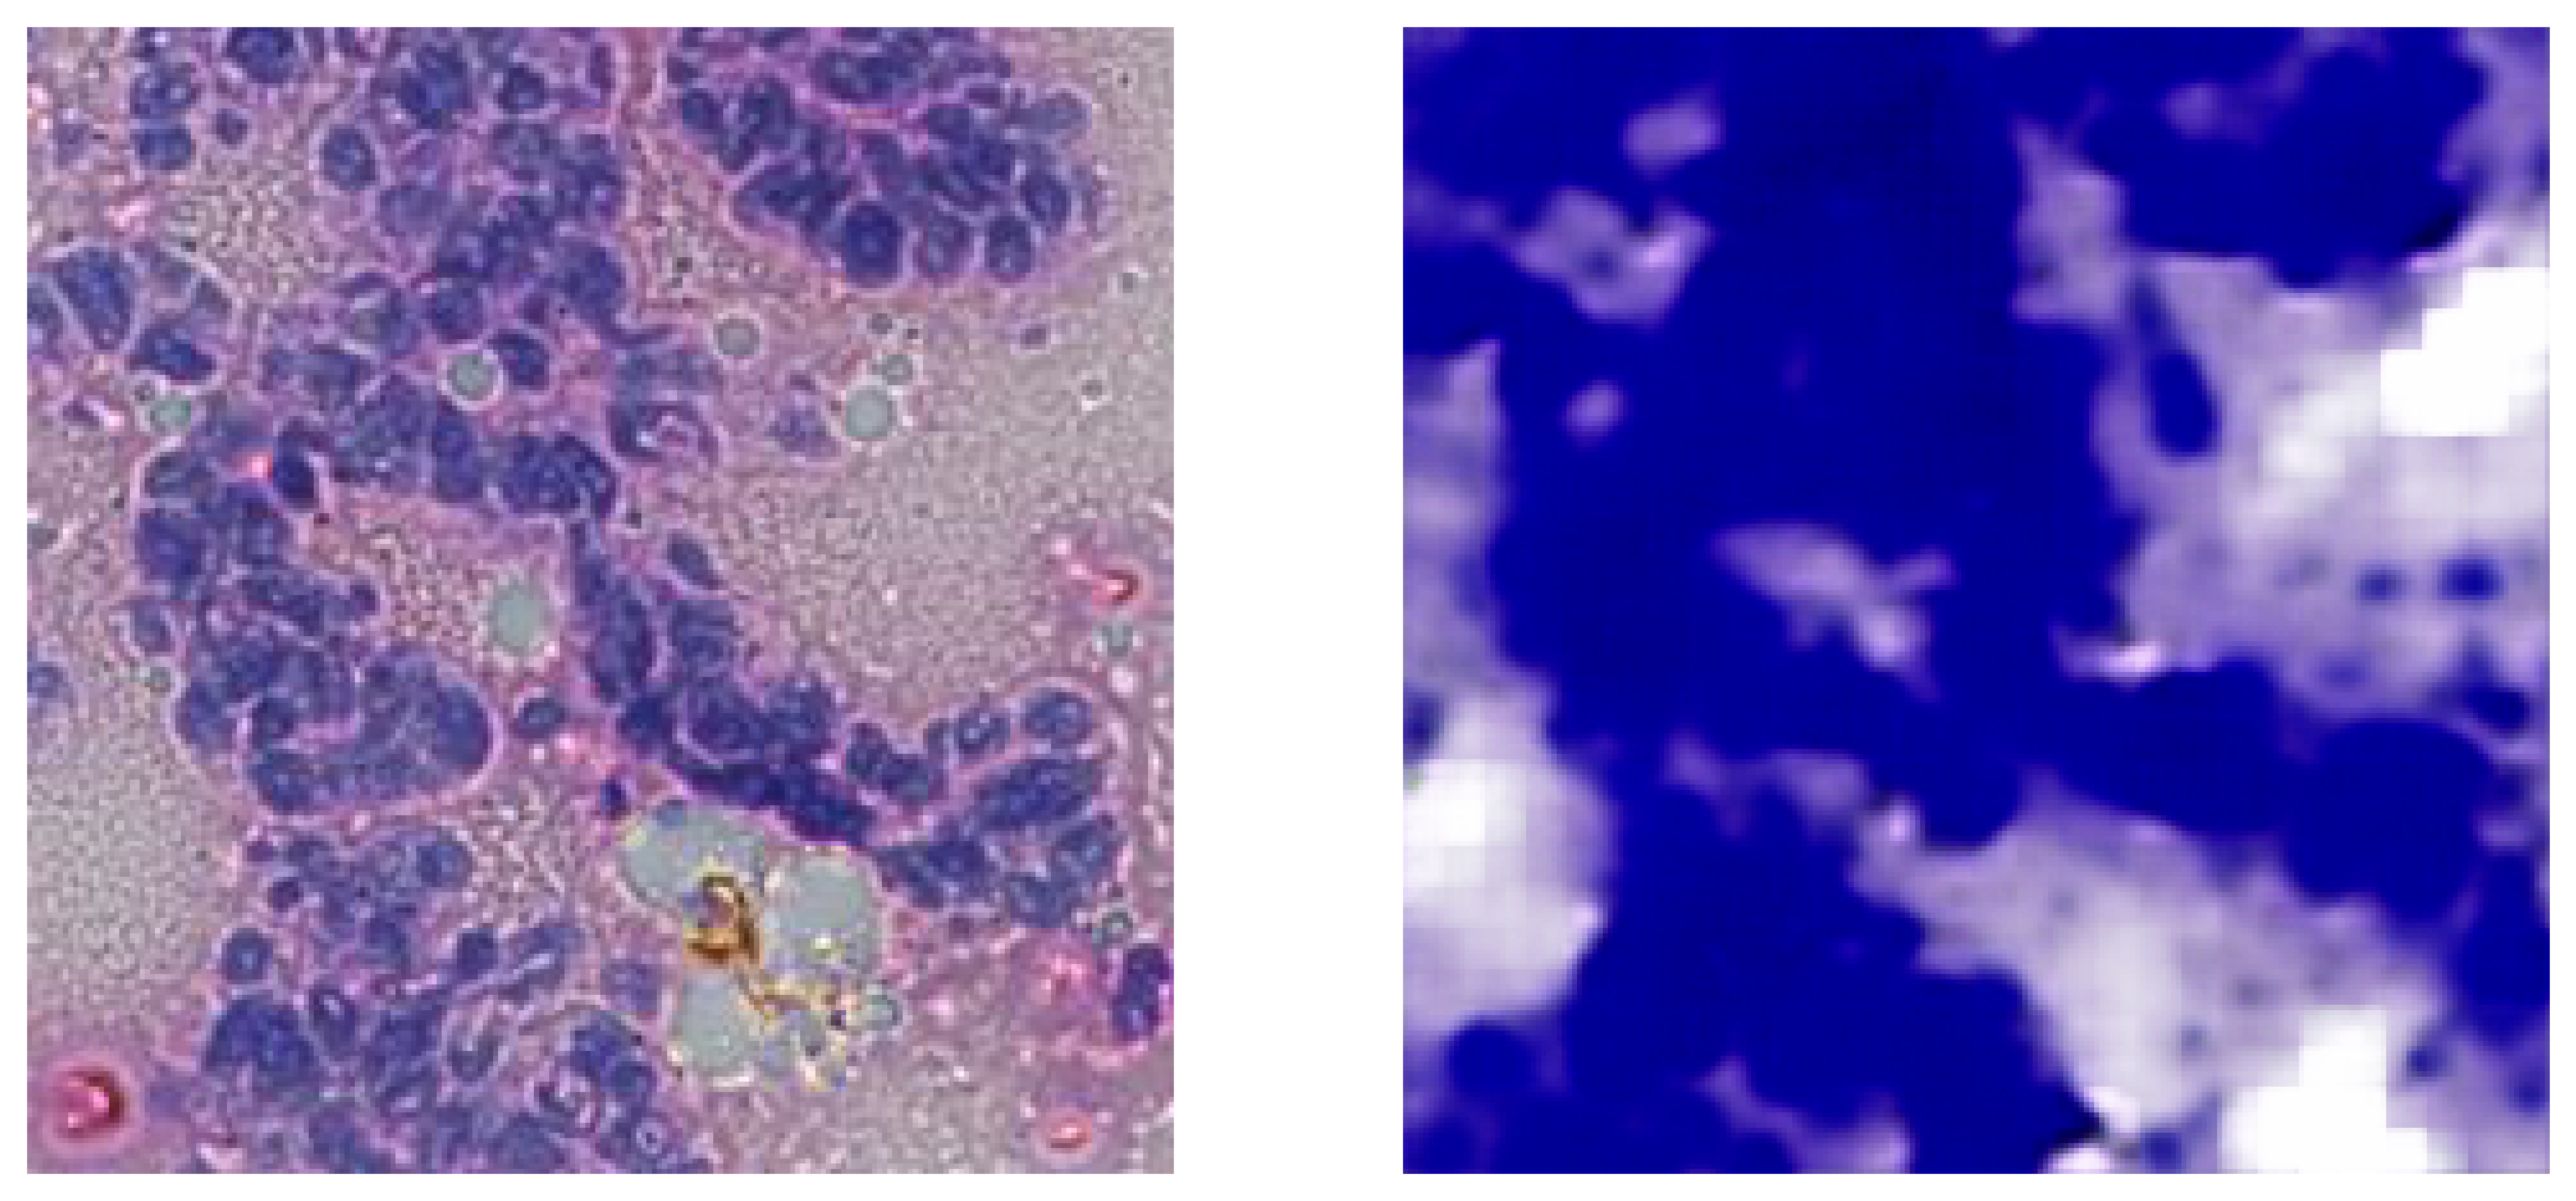

In [17]:
for image_, _, label_ in test_gen.shuffle(2000).take(1):
    
    fig = plt.figure(figsize=(12,12))
    plt.subplot(1, 2, 1)
    plt.imshow(image_.numpy())
    plt.axis('Off')
    
    mean, logvar = model.encode(np.expand_dims(image_.numpy(), axis=0))
    z_sample = model.reparameterize(mean, logvar)
    x_decoded = model.decode_image(z_sample)
    decode_img = tf.reshape(x_decoded[0], (224, 224, 3))    
    
    plt.subplot(1, 2, 2)
    plt.imshow(x_decoded[0])
    plt.axis('Off')
    
    plt.show()

In [99]:

# import matplotlib.pyplot as plt
# from scipy.stats import norm

# digit_size = 224
# n = 15
# figure = np.zeros((digit_size * n, digit_size * n, 3))

# grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
# grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

# for i, yi in enumerate(grid_x):
#     for j, xi in enumerate(grid_y):
#         z_sample = np.array([[xi, yi]])
#         x_decoded = model.sample_image(z_sample)
#         digit = tf.reshape(x_decoded[0], (digit_size, digit_size, 3))
#         figure[i * digit_size: (i + 1) * digit_size,
#                j * digit_size: (j + 1) * digit_size] = digit.numpy()

# plt.figure(figsize=(10, 10))
# plt.imshow(figure)
# plt.axis('Off')
# plt.show()

In [100]:
pred_gene_list = []
for image_, _, label_ in test_gen_:
    mean, logvar = model.encode(image_)
    z_sample = model.reparameterize(mean, logvar)
    x_decoded = model.decode_genes(z_sample)  
    pred_gene_list.append(x_decoded.numpy())

In [101]:
test_dataset.obsm["prediction"] = np.squeeze(np.array(pred_gene_list))

In [16]:
# test_dataset_ = test_dataset[:,gene_list].copy()
# test_dataset_.X = test_dataset.obsm["prediction"] 
# for i, gene in enumerate(gene_list):
#     print("ground truth {}".format(gene))
#     gene_plot(test_dataset, genes=gene)
    
#     print("predicted gene expression {}".format(gene))
#     gene_plot(test_dataset_, genes=gene)

# end

In [8]:
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.utils import plot_model

In [9]:
INPUT_DIM = (128,128,3) # Image dimension
BATCH_SIZE = 512
Z_DIM = 200

In [ ]:
def build_vae(input_dim_en, output_dim_en, conv_filters_en, conv_kernel_size_en, 
                  conv_strides_en, use_batch_norm = False, use_dropout = False):

    n_layers = len(conv_filters_en)

    encoder_input = Input(shape = input_dim, name = 'encoder_input')
    x = encoder_input

    for i in range(n_layers):
        x = Conv2D(filters = conv_filters_en[i], 
                    kernel_size = conv_kernel_size_en[i],
                    strides = conv_strides_en[i], 
                    padding = 'same',
                    name = 'encoder_conv_' + str(i)
                    )(x)
        if use_batch_norm:
            x = BathcNormalization()(x)
  
        x = LeakyReLU()(x)

        if use_dropout:
            x = Dropout(rate=0.25)(x)


    shape_before_flattening = K.int_shape(x)[1:] 
  
    x = Flatten()(x)
  
    mean_mu = Dense(output_dim, name = 'mu')(x)
    log_var = Dense(output_dim, name = 'log_var')(x)


    def sampling(args):
        mean_mu, log_var = args
        epsilon = K.random_normal(shape=K.shape(mean_mu), mean=0., stddev=1.) 
        return mean_mu + K.exp(log_var/2)*epsilon   
  
    encoder_output = Lambda(sampling, name='encoder_output')([mean_mu, log_var])


    return encoder_input, encoder_output, mean_mu, log_var, shape_before_flattening, Model(encoder_input, encoder_output)



In [10]:
# ENCODER
def build_vae_encoder(input_dim, output_dim, conv_filters, conv_kernel_size, 
                  conv_strides, use_batch_norm = False, use_dropout = False):
    
    n_layers = len(conv_filters)

    encoder_input = Input(shape = input_dim, name = 'encoder_input')
    x = encoder_input


    for i in range(n_layers):
        x = Conv2D(filters = conv_filters[i], 
                  kernel_size = conv_kernel_size[i],
                  strides = conv_strides[i], 
                  padding = 'same',
                  name = 'encoder_conv_' + str(i)
                  )(x)
        if use_batch_norm:
            x = BathcNormalization()(x)
  
        x = LeakyReLU()(x)

        if use_dropout:
            x = Dropout(rate=0.25)(x)

    shape_before_flattening = K.int_shape(x)[1:] 
  
    x = Flatten()(x)
  
    mean_mu = Dense(output_dim, name = 'mu')(x)
    log_var = Dense(output_dim, name = 'log_var')(x)


    def sampling(args):
        mean_mu, log_var = args
        epsilon = K.random_normal(shape=K.shape(mean_mu), mean=0., stddev=1.) 
        return mean_mu + K.exp(log_var/2)*epsilon   
  
    encoder_output = Lambda(sampling, name='encoder_output')([mean_mu, log_var])

    return encoder_input, encoder_output, mean_mu, log_var, shape_before_flattening, Model(encoder_input, encoder_output)

vae_encoder_input, vae_encoder_output,  mean_mu, log_var, vae_shape_before_flattening, vae_encoder  = build_vae_encoder(input_dim = INPUT_DIM,
                                    output_dim = Z_DIM, 
                                    conv_filters = [32, 64, 64, 64],
                                    conv_kernel_size = [3,3,3,3],
                                    conv_strides = [2,2,2,2])

In [11]:
# Decoder
def build_decoder(input_dim, shape_before_flattening, conv_filters, conv_kernel_size, 
                  conv_strides):


    n_layers = len(conv_filters)


    decoder_input = Input(shape = (input_dim,) , name = 'decoder_input')


    x = Dense(np.prod(shape_before_flattening))(decoder_input)
    x = Reshape(shape_before_flattening)(x)


    for i in range(n_layers):
        x = Conv2DTranspose(filters = conv_filters[i], 
                  kernel_size = conv_kernel_size[i],
                  strides = conv_strides[i], 
                  padding = 'same',
                  name = 'decoder_conv_' + str(i)
                  )(x)
      

        if i < n_layers - 1:
            x = LeakyReLU()(x)
        else:
            x = Activation('sigmoid')(x)

    decoder_output = x

    return decoder_input, decoder_output, Model(decoder_input, decoder_output)

In [12]:
vae_decoder_input, vae_decoder_output, vae_decoder = build_decoder(input_dim = Z_DIM,
                                        shape_before_flattening = vae_shape_before_flattening,
                                        conv_filters = [64,64,32,3],
                                        conv_kernel_size = [3,3,3,3],
                                        conv_strides = [2,2,2,2]
                                        )

In [13]:

vae_input = vae_encoder.input


vae_output = vae_decoder(vae_encoder.output)


vae_model = Model(vae_encoder.input, vae_output)

In [14]:
vae_output

<KerasTensor: shape=(None, 128, 128, 3) dtype=float32 (created by layer 'model_1')>

In [15]:
vae_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
encoder_conv_0 (Conv2D)         (None, 64, 64, 32)   896         encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 64, 64, 32)   0           encoder_conv_0[0][0]             
__________________________________________________________________________________________________
encoder_conv_1 (Conv2D)         (None, 32, 32, 64)   18496       leaky_re_lu[0][0]                
____________________________________________________________________________________________

In [21]:
images = train_gen_.map(lambda x,y,z : (x,y))

In [22]:
images

<MapDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 3)), types: (tf.float32, tf.float32)>

In [121]:
dataset = images.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)

In [122]:
images_ = zip(images,images)

In [25]:
LEARNING_RATE = 0.0005
N_EPOCHS = 10
LOSS_FACTOR = 10000


def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

def kl_loss(y_true, y_pred):
    kl_loss =  -0.5 * K.sum(1 + log_var - K.square(mean_mu) - K.exp(log_var), axis = 1)
    return kl_loss

def total_loss(y_true, y_pred):
    return LOSS_FACTOR*r_loss(y_true, y_pred) + kl_loss(y_true, y_pred)
  
adam_optimizer = Adam(lr = LEARNING_RATE)

vae_model.compile(optimizer=adam_optimizer, loss = total_loss, metrics = [r_loss, kl_loss])

# checkpoint_vae = ModelCheckpoint(os.path.join(WEIGHTS_FOLDER, 'VAE/weights.h5'), save_weights_only = True, verbose=1)

vae_model.fit(images,
                        epochs = N_EPOCHS)

Epoch 1/10


TypeError: in user code:

    /scratch/imb/Xiao/.conda/envs/stimage/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /scratch/imb/Xiao/.conda/envs/stimage/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /scratch/imb/Xiao/.conda/envs/stimage/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /scratch/imb/Xiao/.conda/envs/stimage/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /scratch/imb/Xiao/.conda/envs/stimage/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /scratch/imb/Xiao/.conda/envs/stimage/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /scratch/imb/Xiao/.conda/envs/stimage/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:755 train_step
        loss = self.compiled_loss(
    /scratch/imb/Xiao/.conda/envs/stimage/lib/python3.8/site-packages/tensorflow/python/keras/engine/compile_utils.py:237 __call__
        self._loss_metric.update_state(
    /scratch/imb/Xiao/.conda/envs/stimage/lib/python3.8/site-packages/tensorflow/python/keras/utils/metrics_utils.py:90 decorated
        update_op = update_state_fn(*args, **kwargs)
    /scratch/imb/Xiao/.conda/envs/stimage/lib/python3.8/site-packages/tensorflow/python/keras/metrics.py:177 update_state_fn
        return ag_update_state(*args, **kwargs)
    /scratch/imb/Xiao/.conda/envs/stimage/lib/python3.8/site-packages/tensorflow/python/keras/metrics.py:363 update_state  **
        sample_weight = weights_broadcast_ops.broadcast_weights(
    /scratch/imb/Xiao/.conda/envs/stimage/lib/python3.8/site-packages/tensorflow/python/ops/weights_broadcast_ops.py:155 broadcast_weights
        values = ops.convert_to_tensor(values, name="values")
    /scratch/imb/Xiao/.conda/envs/stimage/lib/python3.8/site-packages/tensorflow/python/profiler/trace.py:163 wrapped
        return func(*args, **kwargs)
    /scratch/imb/Xiao/.conda/envs/stimage/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:1540 convert_to_tensor
        ret = conversion_func(value, dtype=dtype, name=name, as_ref=as_ref)
    /scratch/imb/Xiao/.conda/envs/stimage/lib/python3.8/site-packages/tensorflow/python/framework/constant_op.py:339 _constant_tensor_conversion_function
        return constant(v, dtype=dtype, name=name)
    /scratch/imb/Xiao/.conda/envs/stimage/lib/python3.8/site-packages/tensorflow/python/framework/constant_op.py:264 constant
        return _constant_impl(value, dtype, shape, name, verify_shape=False,
    /scratch/imb/Xiao/.conda/envs/stimage/lib/python3.8/site-packages/tensorflow/python/framework/constant_op.py:281 _constant_impl
        tensor_util.make_tensor_proto(
    /scratch/imb/Xiao/.conda/envs/stimage/lib/python3.8/site-packages/tensorflow/python/framework/tensor_util.py:435 make_tensor_proto
        values = np.asarray(values)
    /scratch/imb/Xiao/.conda/envs/stimage/lib/python3.8/site-packages/numpy/core/_asarray.py:83 asarray
        return array(a, dtype, copy=False, order=order)
    /scratch/imb/Xiao/.conda/envs/stimage/lib/python3.8/site-packages/tensorflow/python/keras/engine/keras_tensor.py:273 __array__
        raise TypeError(

    TypeError: Cannot convert a symbolic Keras input/output to a numpy array. This error may indicate that you're trying to pass a symbolic value to a NumPy call, which is not supported. Or, you may be trying to pass Keras symbolic inputs/outputs to a TF API that does not register dispatching, preventing Keras from automatically converting the API call to a lambda layer in the Functional Model.


In [104]:
DATA_FOLDER = "/tmp/tiles/"
data_flow = ImageDataGenerator(rescale=1./255).flow_from_directory(DATA_FOLDER, 
                                                                   target_size = INPUT_DIM[:2],
                                                                   batch_size = 10,
                                                                   shuffle = True,
                                                                   class_mode = "input",
                                                                   subset = 'training'
                                                                   )

Found 23355 images belonging to 2 classes.


In [102]:
data_flow